## Аналитика в Яндекс.Афише

### Описание проекта   

Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:  

- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

### Описание данных  

#### Таблица visits (лог сервера с информацией о посещениях сайта):

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь  

#### Таблица orders (информация о заказах):  

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа  

#### Таблица costs (информация о затратах на маркетинг):  

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

<a id='back'><a/> 
# Задачи исследования
    
### [1. Изучение данных](#1)

- Загрузить данные о визитах, заказах и расходах в переменные 
- Оптимизировать данные для анализа 
- Убедиться, что тип данных в каждой колонке — правильный

### [2. Построение отчётов и подсчет метрик](#2)  
#### [2.1 Продукт. Сколько людей пользуются в день, неделю, месяц.](#2.1)
#### [2.2 Продукт. Сколько сессий в день.](#2.2)
#### [2.3 Продукт. Сколько длится одна сессия.](#2.3)
#### [2.3.1 Продукт. Сколько длится одна сессия на разных.](#2.3.1)
#### [2.3.2 Продукт. Как часто люди возвращаются.](#2.3.2)

### [3. Продажи](#3)  
#### [3.1 Продажи. Когда люди начинают покупать.](#3.1)
#### [3.2 Продажи. Сколько раз покупают за период.](#3.2)
#### [3.3 Продажи. Какой средний чек.](#3.3)
#### [3.4 Продажи. Сколько денег приносят (LTV).](#3.4)

### [4. Маркетинг](#4)  
#### [4.1 Маркетинг. Сколько денег потратили. Всего / на каждый источник / по времени.](#4.1)
#### [4.2 Маркетинг. Сколько стоило привлечение одного покупателя из каждого источника.](#4.2)
#### [4.3 Маркетинг. На сколько окупились расходы (ROI).](#4.3)

### [5. Вывод. Рекомендации маркетологам, куда и сколько им стоит вкладывать денег.](#5)  

Приступим к исследованию.

<a id='1'><a/> 
## 1. Изучение данных
[Назад к оглавлению](#back)

In [1]:
#импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime

from functools import reduce
idx = pd.IndexSlice
import plotly.graph_objects as go

In [2]:
#прочитаем таблицы и сохраним в датафреймы
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

#для удобства отобразим все колонки таблицы 
pd.set_option('display.max_columns', None)

In [3]:
#посмотрим таблицу логов сервера с информацией о посещениях сайта
visits.sample(10)

,Device,End Ts,Source Id,Start Ts,Uid
273217,touch,2017-11-22 09:12:00,4,2017-11-22 09:11:00,2464040357920947582
178357,touch,2017-12-16 00:46:00,4,2017-12-16 00:38:00,12095965595240138359
71089,touch,2018-04-21 01:51:00,1,2018-04-21 01:35:00,6959378452854096727
38691,touch,2018-05-03 20:25:00,4,2018-05-03 19:58:00,11684259320925930097
34462,touch,2017-11-06 19:22:00,4,2017-11-06 19:19:00,17288639231066021048
226,desktop,2017-07-25 14:51:00,5,2017-07-25 14:29:00,13911328034968772848
193695,touch,2017-10-31 05:47:00,1,2017-10-31 05:19:00,17229994363292275914
240427,desktop,2017-12-18 12:10:00,5,2017-12-18 11:50:00,12754878565270889837
319793,desktop,2018-02-21 10:38:00,10,2018-02-21 10:21:00,17060387559290710704
225585,desktop,2017-12-18 16:06:00,4,2017-12-18 16:05:00,17971235230663471398


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
#заменим названия столбцов
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [6]:
#приведм тип данных в столбцах с датой и времени к формату datetime
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [7]:
#посмотрим таблицу с информацией о заказах
orders.sample(10)

,Buy Ts,Revenue,Uid
5137,2017-08-10 12:26:00,2.44,5141942806247901220
31989,2018-01-31 09:24:00,0.37,7454064079217322646
12387,2017-10-12 14:42:00,0.30,9949730060386648841
42000,2018-03-26 11:52:00,0.18,17964637413613047432
23881,2017-12-13 18:31:00,1.67,9213776284216051797
27964,2018-01-04 00:32:00,2.44,9842663369399282000
15766,2017-11-02 10:48:00,1.47,3469770939670600351
41916,2018-03-25 22:12:00,2.14,924000468520212654
20496,2017-11-27 16:40:00,23.83,5539673724080479777
24816,2017-12-18 22:44:00,5.50,8642644440873723386


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
#заменим названия столбцов
orders.columns = ['buy_ts', 'revenue', 'uid']

In [10]:
#приведм тип данных в столбце с датой и времени к формату datetime
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [11]:
#проверим, есть ли данные, где выручка меньше либо равна нулю
orders[orders['revenue'] <= 0]

,buy_ts,revenue,uid
1802,2017-06-22 18:19:00,0.0,17030528792926543083
2787,2017-07-07 15:54:00,0.0,10281425020415612933
4783,2017-08-02 14:54:00,0.0,184148767273119549
5095,2017-08-09 14:48:00,0.0,5603453646174104178
5863,2017-08-23 13:43:00,0.0,5603453646174104178
6393,2017-08-30 16:30:00,0.0,5603453646174104178
6995,2017-09-06 13:57:00,0.0,5603453646174104178
7104,2017-09-07 14:37:00,0.0,5603453646174104178
7488,2017-09-11 16:53:00,0.0,10169885790465067808
8160,2017-09-18 16:49:00,0.0,2883839899480223178


In [12]:
len(orders[orders['revenue'] <= 0])

51

Таких строк у нас 51, в масштабах выборки это незначительно, поэтому мы удалим эти строки.

In [13]:
#удалим строки
orders = orders.drop(orders[orders['revenue'] <= 0].index)

In [14]:
#посмотрим таблицу с информацией о затратах на маркетинг
costs.sample(10)

,source_id,dt,costs
567,2,2017-12-22,90.53
2272,10,2017-09-02,3.70
1396,4,2018-04-06,118.28
843,3,2017-09-26,531.85
493,2,2017-10-09,152.23
617,2,2018-02-10,253.15
1086,3,2018-05-29,347.59
185,1,2017-12-03,69.72
978,3,2018-02-08,379.87
1097,4,2017-06-09,446.64


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [16]:
#приведм тип данных в столбце с датой и времени к формату datetime
costs['dt'] = pd.to_datetime(costs['dt'])

In [17]:
#проверим наличие дубликатов в таблицах
visits.duplicated().sum()
orders.duplicated().sum()
costs.duplicated().sum()

0

#### Вывод

Во всех трех таблицах нет пропущенных значений и дубликатов. Типы данных в столбцах с датами заменили на формат datetime. Теперь данные готовы к дальнейшему исследованию.

<a id='2'><a/> 
## 2. Построение отчётов и подсчет метрик
[Назад к оглавлению](#back)

<a id='2.1'><a/> 
#### 2.1 Продукт. Сколько людей пользуются в день, неделю, месяц.
[Назад к оглавлению](#back)

In [18]:
#добавим столбцы с датой, неделей, месяцем и их названиями, годом
visits['ts_date'] = visits['start_ts'].dt.date
visits['day_number'] = visits['start_ts'].dt.day
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['week_number'] = visits['start_ts'].dt.week
visits['day_of_week'] = visits['start_ts'].dt.day_name()
visits['day_of_week_number'] = visits['start_ts'].dt.dayofweek
visits['month_name'] = visits['start_ts'].dt.month_name()

In [19]:
visits.head()

,device,end_ts,source_id,start_ts,uid,ts_date,day_number,month,year,week_number,day_of_week,day_of_week_number,month_name
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,12,2017,51,Wednesday,2,December
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,2,2018,8,Monday,0,February
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,7,2017,26,Saturday,5,July
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,20,Sunday,6,May
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,12,2017,52,Wednesday,2,December


In [20]:
#проверим, есть ли некорректные значения в столбцах времени начала и конца сессий
visits[visits['start_ts'] > visits['end_ts']]

,device,end_ts,source_id,start_ts,uid,ts_date,day_number,month,year,week_number,day_of_week,day_of_week_number,month_name
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-25,25,3,2018,12,Sunday,6,March
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-25,25,3,2018,12,Sunday,6,March


В таблице присутствуют две строки, в которых время начала сессии больше времени конца, что будет давать искажение в данных. В масштабах выборки две строки это мало, поэтому мы удалим их.

In [21]:
#удалим строки
visits = visits.drop(visits[visits['start_ts'] > visits['end_ts']].index)

In [22]:
#для удобства работы с таблицой, поменяем положение столбцов с логикой их расположения 
visits = visits[[
 'device',  
 'source_id',
 'ts_date',
 'start_ts',
 'end_ts',
 'uid',
 'year',
 'month',
 'month_name',
 'week_number',
 'day_number',
 'day_of_week_number',
 'day_of_week'
]]

visits.sample(5)

,device,source_id,ts_date,start_ts,end_ts,uid,year,month,month_name,week_number,day_number,day_of_week_number,day_of_week
122279,desktop,5,2018-03-08,2018-03-08 15:30:00,2018-03-08 16:00:00,12116979760952147813,2018,3,March,10,8,3,Thursday
166710,desktop,2,2018-04-20,2018-04-20 22:50:00,2018-04-20 22:54:00,11180742257983029498,2018,4,April,16,20,4,Friday
135177,touch,4,2017-11-19,2017-11-19 14:27:00,2017-11-19 14:32:00,3255081435991002799,2017,11,November,46,19,6,Sunday
26405,desktop,5,2017-12-06,2017-12-06 16:50:00,2017-12-06 17:08:00,11918911267132945834,2017,12,December,49,6,2,Wednesday
253657,touch,3,2017-08-01,2017-08-01 16:06:00,2017-08-01 16:09:00,16760504694020355170,2017,8,August,31,1,1,Tuesday


Мы добавили в таблицу логов сервера с информацией о посещениях сайта новые столбцы с датой, годом, месяцем, именем месяца, номером недели, номером дня, номером дня в неделе и названием дня недели для удобства восприятия информации и дальнейшей работы с данными. теперь мы можем посчитать DAU, MAU и WAU.

### Среднее количество уникальных пользователей в день

In [23]:
#посчитаем среднее количествопользователей в день
DAU = visits.groupby('ts_date').agg({'uid': 'nunique'}).mean()
print("Ежедневная аудитория DAU {0:.2f} человек".format(DAU[0]))

Ежедневная аудитория DAU 907.99 человек


In [24]:
#посмотрим среднее количество пользователей в день по устройствам
visits.pivot_table(index='ts_date', columns='device', values='uid', aggfunc='nunique').mean()

device
desktop    659.244505
touch      252.873278
dtype: float64

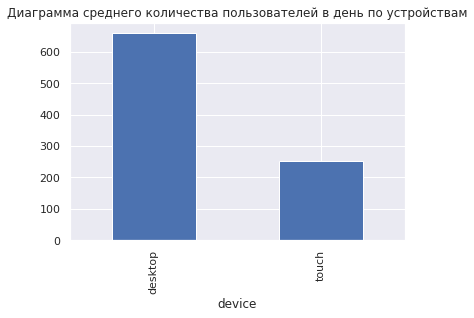

In [25]:
visits.pivot_table(index='ts_date', columns='device', values='uid', aggfunc='nunique').mean().plot(kind='bar')
plt.title('Диаграмма среднего количества пользователей в день по устройствам')
plt.show()

In [26]:
len(visits[visits['device'] == 'desktop']) / len(visits[visits['device'] == 'touch'])

2.7115239639379136

In [27]:
#посмотрим среднее количествопользователей в день по источникам
visits.pivot_table(index='ts_date', columns='source_id', values='uid', aggfunc='nunique').mean().sort_values(ascending=False)

source_id
4     275.454545
3     232.862259
5     175.622590
2     120.707989
1      80.557692
9      36.110193
10     26.033058
7       1.058824
6       1.000000
dtype: float64

In [28]:
#посмотрим уникальные значения источников
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

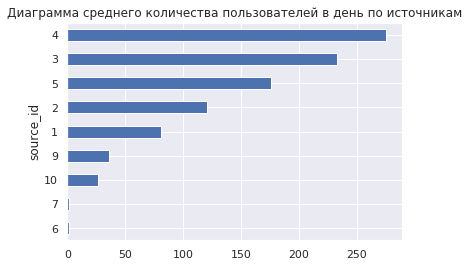

In [29]:
visits.pivot_table(index='ts_date', columns='source_id', values='uid', aggfunc='nunique').mean().sort_values(ascending=True).plot(kind='barh')
plt.title('Диаграмма среднего количества пользователей в день по источникам')
plt.show()

С десктопной версии компьютера переходов больше, чем с мобильной в 2.7 раза. Так же мы видим, что наибольшее число переходов из источника 4 и в списке источников не хватает источника под номером 8. Не понятно, мы намеренно его не исследуем или он потерялся при выгрузке, этот момент нужно уточнить.

### Среднее количество уникальных пользователей в неделю

In [30]:
#посчитаем среднее количествопользователей в неделю
WAU = visits.groupby('week_number').agg({'uid': 'nunique'}).mean()
print("Еженедельная аудитория WAU {0:.2f} человек".format(WAU[0]))

Еженедельная аудитория WAU 5825.29 человек


In [31]:
#посмотрим среднее количество пользователей в неделю по устройствам
visits.pivot_table(index='week_number', columns='device', values='uid', aggfunc='nunique').mean()

device
desktop    4208.173077
touch      1666.230769
dtype: float64

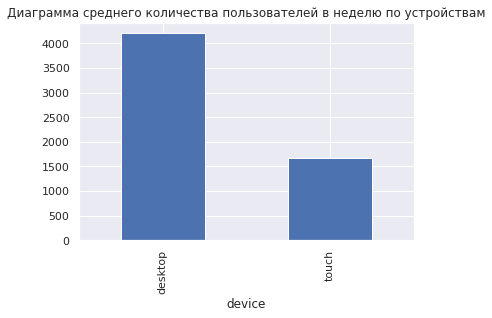

In [32]:
visits.pivot_table(index='week_number', columns='device', values='uid', aggfunc='nunique').mean().plot(kind='bar')
plt.title('Диаграмма среднего количества пользователей в неделю по устройствам')
plt.show()

In [33]:
#посмотрим среднее количествопользователей в неделю по источникам
visits.pivot_table(index='week_number', columns='source_id', values='uid', aggfunc='nunique').mean().sort_values(ascending=False)

source_id
4     1864.365385
3     1595.980769
5     1189.903846
2      729.192308
1      472.173077
9      243.288462
10     169.750000
7        1.333333
6        1.000000
dtype: float64

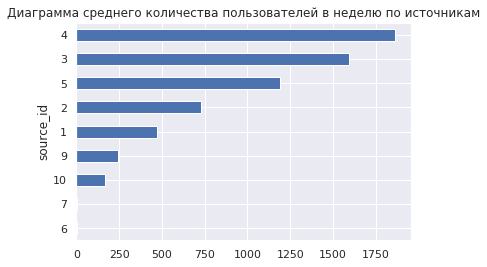

In [34]:
visits.pivot_table(index='week_number', columns='source_id', values='uid', aggfunc='nunique').mean().sort_values(ascending=True).plot(kind='barh')
plt.title('Диаграмма среднего количества пользователей в неделю по источникам')
plt.show()

### Среднее количество уникальных пользователей в месяц

In [35]:
MAU = visits.groupby('month').agg({'uid': 'nunique'}).mean()
print("Ежемесячная аудитория MAU {0:.2f} человек".format(MAU[0]))

Ежемесячная аудитория MAU 23228.42 человек


In [36]:
#посмотрим среднее количество пользователей в месяц по устройствам
visits.pivot_table(index='month', columns='device', values='uid', aggfunc='nunique').mean()

device
desktop    16724.916667
touch       6825.916667
dtype: float64

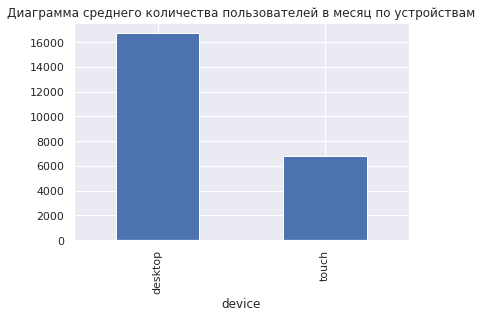

In [37]:
visits.pivot_table(index='month', columns='device', values='uid', aggfunc='nunique').mean().plot(kind='bar')
plt.title('Диаграмма среднего количества пользователей в месяц по устройствам')
plt.show()

In [38]:
#посмотрим среднее количествопользователей в месяц по источникам
visits.pivot_table(index='month', columns='source_id', values='uid', aggfunc='nunique').mean().sort_values(ascending=False)

source_id
4     7765.666667
3     6758.750000
5     5017.916667
2     2752.083333
1     1818.750000
9      987.000000
10     707.000000
7        2.833333
6        1.000000
dtype: float64

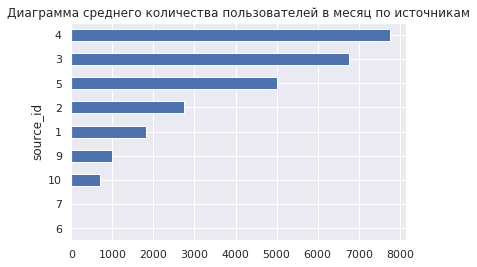

In [39]:
visits.pivot_table(index='month', columns='source_id', values='uid', aggfunc='nunique').mean().sort_values(ascending=True).plot(kind='barh')
plt.title('Диаграмма среднего количества пользователей в месяц по источникам')
plt.show()

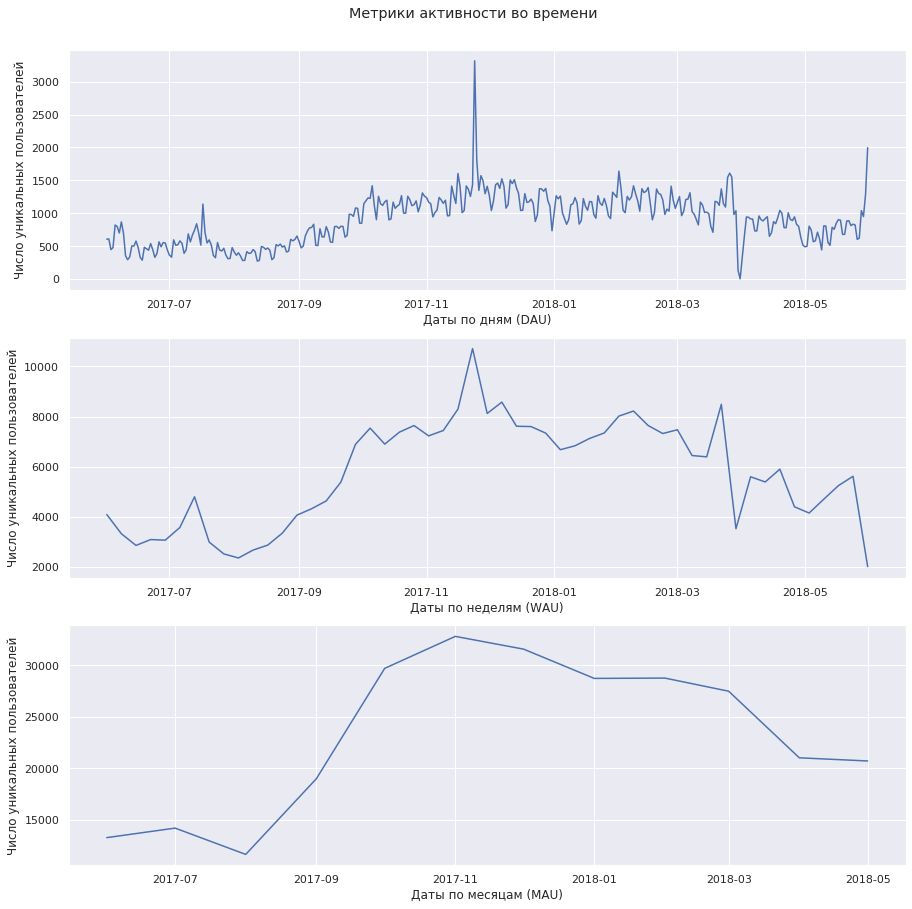

In [40]:
#посмотрим графики динамики изменения DAU, WAU и MAU
fig, ax = plt.subplots(3, 1, figsize=(15,15))
 
# добавляем графики циклом
i = 0
for name, period in {'дням (DAU)': 'datetime64[D]', 
                     'неделям (WAU)': 'datetime64[W]', 
                     'месяцам (MAU)': 'datetime64[M]'}.items():
    data = visits.groupby([visits['start_ts'].astype(period)]).agg({'uid': 'nunique'}).reset_index()
    sns.lineplot(data=data, y='uid', x='start_ts', ax=ax[i]).set(xlabel='Даты по '+name, ylabel='Число уникальных пользователей')   
    i += 1
 
plt.suptitle('Метрики активности во времени', y=0.92);

In [41]:
visits.head()

,device,source_id,ts_date,start_ts,end_ts,uid,year,month,month_name,week_number,day_number,day_of_week_number,day_of_week
0,touch,4,2017-12-20,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,2017,12,December,51,20,2,Wednesday
1,desktop,2,2018-02-19,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2018,2,February,8,19,0,Monday
2,touch,5,2017-07-01,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,2017,7,July,26,1,5,Saturday
3,desktop,9,2018-05-20,2018-05-20 10:59:00,2018-05-20 11:23:00,16174680259334210214,2018,5,May,20,20,6,Sunday
4,desktop,3,2017-12-27,2017-12-27 14:06:00,2017-12-27 14:06:00,9969694820036681168,2017,12,December,52,27,2,Wednesday


#### Вывод

- Ежедневная аудитория DAU - 907.99 человек
- Еженедельная аудитория WAU - 5825.29 человек
- Ежемесячная аудитория MAU 23228.42 человек

Просмотров с десктопной версии с компьютера более чем в 2 раза больше, чем с мобильной версии. Больше всего переходов из источника номер 4. Среднее количество переходов из источников и с устройств имеет одинаковую тенденцию по дням, неделям и месяцам.  

По среднему количеству уникальных пользователей в день/неделю/месяц мы видим, что пиковые значения приходятся на конец осени-начало зимы (ноябрь, декабрь). Это может быть признаком сезонности, так как эти месяцы являются разгаром ивент-сезона и проводится много мероприятий.

<a id='2.2'><a/> 
#### 2.2 Продукт. Сколько сессий в день.<a id='2.1'><a/> 
[Назад к оглавлению](#back)

In [42]:
session_count = visits.groupby('ts_date').agg({'uid': 'count'}).mean()
print("Среднее количество сессий в день {0:.2f} ".format(session_count[0]))

Среднее количество сессий в день 987.36 


In [43]:
#создадим отдельную таблицу по сессиям пользователей
sessions_per_user = visits.groupby(['ts_date']).agg({'uid':['nunique', 'count']})
sessions_per_user.columns = ['n_users', 'n_sessions']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

,n_users,n_sessions,sessions_per_user
ts_date,,,
2017-06-01,605,664,1.097521
2017-06-02,608,658,1.082237
2017-06-03,445,477,1.071910
2017-06-04,476,510,1.071429
2017-06-05,820,893,1.089024
...,...,...,...
2018-05-27,620,672,1.083871
2018-05-28,1039,1156,1.112608
2018-05-29,948,1035,1.091772


In [44]:
#посмотрим среднее значение посещений для пользователей
sessions_per_user['sessions_per_user'].mean()

1.0821660876897359

#### Вывод  

Среднее количество сессий в день 987.36  
Большинство пользователей посещают сайт Яндекс.Афиши не более одного раза в день.

<a id='2.3'><a/> 
#### 2.3 Продукт. Сколько длится одна сессия.<a id='2.1'><a/> 
[Назад к оглавлению](#back)

In [45]:
#посмотрим среднее значение длительности одной сессии
((visits['end_ts'] - visits['start_ts']).dt.seconds).mean()

643.0422873805642

In [46]:
print('Средняя длительность одной сессии в минутах:', ((visits['end_ts'] - visits['start_ts']).dt.seconds).mean() / 60)

Средняя длительность одной сессии в минутах: 10.717371456342736


In [47]:
#добавим с таблицу столбец с 
visits['session_duration_minutes'] = ((visits['end_ts'] - visits['start_ts']).dt.seconds) / 60

In [48]:
visits['session_duration_minutes'].describe()

count    359398.000000
mean         10.717371
std          16.618420
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration_minutes, dtype: float64

Text(0, 0.5, 'Количество сессий')

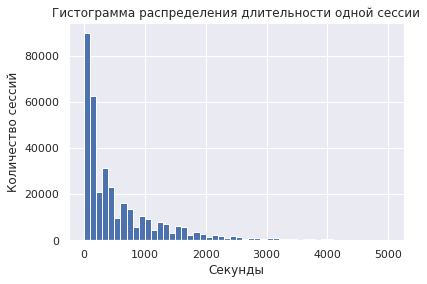

In [49]:
#посмотрим на гистограмму распределения длительности одной сессии
((visits['end_ts'] - visits['start_ts']).dt.seconds).hist(bins=50, range = (0,5000))
plt.title('Гистограмма распределения длительности одной сессии')
plt.xlabel('Секунды')
plt.ylabel('Количество сессий')

В данных присуствуют выбросы в виде аномально долгих сессий.

In [50]:
#среднее значение
visits['session_duration_minutes'].mean()

10.717371456342736

In [51]:
#медианное значение
visits['session_duration_minutes'].median()

5.0

In [52]:
#мода
visits['session_duration_minutes'].mode()

0    1.0
dtype: float64

In [53]:
visits['session_duration_minutes'].value_counts()

1.0      53029
0.0      35794
2.0      35748
3.0      26672
4.0      21085
         ...  
335.0        1
484.0        1
248.0        1
333.0        1
524.0        1
Name: session_duration_minutes, Length: 310, dtype: int64

In [54]:
#посмотрим какой процент составляют сессию в 1 минуту
53029 / len(visits) * 100

14.754951335288455

#### Вывод  

Среднее значение длительности одной сессии - 10 минут
Медианное значение длительности одной сессии - 5 минут
Мода длительности одной сессии - 1 минута

Выбросы сильно влияют на показатель среднего значения, которое в 2 раза больше медианного. Медианное значение равно 5 минутам, однако, самое часто встречающееся значение длительности сессии это 1 минута. Сессии длительностью в минуту составляют всего 14.7% от общего числа сессий, поэтому будем считать, что медиана наиболе достоверно отображает длительность одной сессии.

<a id='2.3.1'><a/> 
#### 2.3.1 Продукт. Сколько длится одна сессия на разных устройствах.<a id='2.1'><a/> 
[Назад к оглавлению](#back)

Text(0, 0.5, 'Количество сессий')

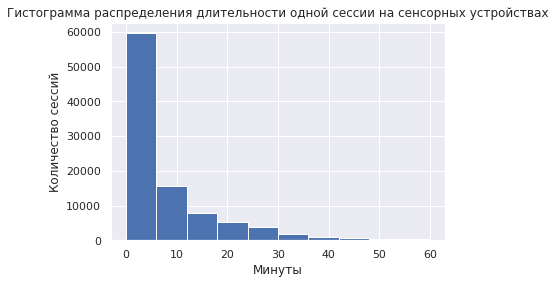

In [55]:
#для тач-устройств
visits[visits['device'] == 'touch']['session_duration_minutes'].hist(range=(0,60))
plt.title('Гистограмма распределения длительности одной сессии на сенсорных устройствах')
plt.xlabel('Минуты')
plt.ylabel('Количество сессий')

Text(0, 0.5, 'Количество сессий')

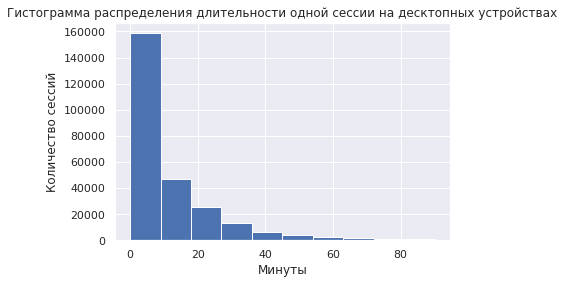

In [56]:
#для десктоп-устройств
visits[visits['device'] == 'desktop']['session_duration_minutes'].hist(range=(0,90))
plt.title('Гистограмма распределения длительности одной сессии на десктопных устройствах')
plt.xlabel('Минуты')
plt.ylabel('Количество сессий')

In [57]:
#медианное значение длительности одной сессии на сенсорных устройствах
visits[visits['device'] == 'touch']['session_duration_minutes'].median()

3.0

In [58]:
#медианное значение длительности одной сессии на десктопных устройствах
visits[visits['device'] == 'desktop']['session_duration_minutes'].median()

6.0

#### Вывод  

В среднем пользоватили десктопных устройств проводят в два раза больше времени на сайте, чем с сенсорных. Так же мы видим, что на десктопных устройствах есть значения более 60 минут.

<a id='2.3.2'><a/> 
#### 2.3.2 Продукт. Как часто люди возвращаются.<a id='2.1'><a/> 
[Назад к оглавлению](#back)

In [59]:
#создадим таблицу с данными по первому визиту пользователей
first_visit = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']
first_visit.head()

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [60]:
#добавим новый столбец с датой первого посещения присоединив таблицы
visits = visits.merge(first_visit)
visits.sample(5)

,device,source_id,ts_date,start_ts,end_ts,uid,year,month,month_name,week_number,day_number,day_of_week_number,day_of_week,session_duration_minutes,first_visit
229561,desktop,9,2018-03-27,2018-03-27 21:31:00,2018-03-27 22:09:00,2364759599337813112,2018,3,March,13,27,1,Tuesday,38.0,2017-08-10 12:14:00
205640,touch,4,2017-10-26,2017-10-26 20:15:00,2017-10-26 20:15:00,3927263590327248033,2017,10,October,43,26,3,Thursday,0.0,2017-10-24 06:17:00
241900,desktop,9,2017-08-31,2017-08-31 16:30:00,2017-08-31 16:31:00,14146003845011683162,2017,8,August,35,31,3,Thursday,1.0,2017-08-31 16:30:00
87325,desktop,4,2017-12-27,2017-12-27 17:20:00,2017-12-27 17:24:00,11995951295262077971,2017,12,December,52,27,2,Wednesday,4.0,2017-12-05 17:40:00
190933,desktop,4,2018-03-12,2018-03-12 16:05:00,2018-03-12 16:05:00,163140261532263830,2018,3,March,11,12,0,Monday,0.0,2018-03-12 16:05:00


In [61]:
#выделим месяцы из дат в таблице
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

In [62]:
#найдем lifetime когорт
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [63]:
visits.sample(5)

,device,source_id,ts_date,start_ts,end_ts,uid,year,month,month_name,week_number,day_number,day_of_week_number,day_of_week,session_duration_minutes,first_visit,first_visit_month,visit_month,cohort_lifetime
252466,touch,4,2017-09-11,2017-09-11 09:08:00,2017-09-11 09:12:00,2671063716983181469,2017,9,September,37,11,0,Monday,4.0,2017-09-11 09:08:00,2017-09-01,2017-09-01,0
48808,touch,2,2017-11-30,2017-11-30 17:56:00,2017-11-30 18:10:00,5658058026664385766,2017,11,November,48,30,3,Thursday,14.0,2017-11-29 22:58:00,2017-11-01,2017-11-01,0
77377,desktop,5,2018-01-26,2018-01-26 12:37:00,2018-01-26 13:22:00,5418311721112952848,2018,1,January,4,26,4,Friday,45.0,2018-01-20 20:01:00,2018-01-01,2018-01-01,0
286868,desktop,5,2017-07-23,2017-07-23 23:52:00,2017-07-23 23:53:00,2848575261809916660,2017,7,July,29,23,6,Sunday,1.0,2017-07-23 23:52:00,2017-07-01,2017-07-01,0
124914,desktop,1,2017-07-12,2017-07-12 18:32:00,2017-07-12 18:35:00,3851754155884509803,2017,7,July,28,12,2,Wednesday,3.0,2017-07-06 12:23:00,2017-07-01,2017-07-01,0


In [64]:
#получим когорты
visit_cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
visit_cohorts

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [65]:
initial_visiters_count = visit_cohorts[visit_cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_visiters_count = initial_visiters_count.rename(columns={'uid':'cohort_visiters'})
initial_visiters_count

,first_visit_month,cohort_visiters
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [66]:
visit_cohorts = visit_cohorts.merge(initial_visiters_count, on='first_visit_month')
visit_cohorts

,first_visit_month,cohort_lifetime,uid,cohort_visiters
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [67]:
#посчитаем retention и добавим его в новый столбец
visit_cohorts['retention'] = visit_cohorts['uid'] / visit_cohorts['cohort_visiters'] 
visit_cohorts

,first_visit_month,cohort_lifetime,uid,cohort_visiters,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


In [68]:
retention_visits = visit_cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_visits

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


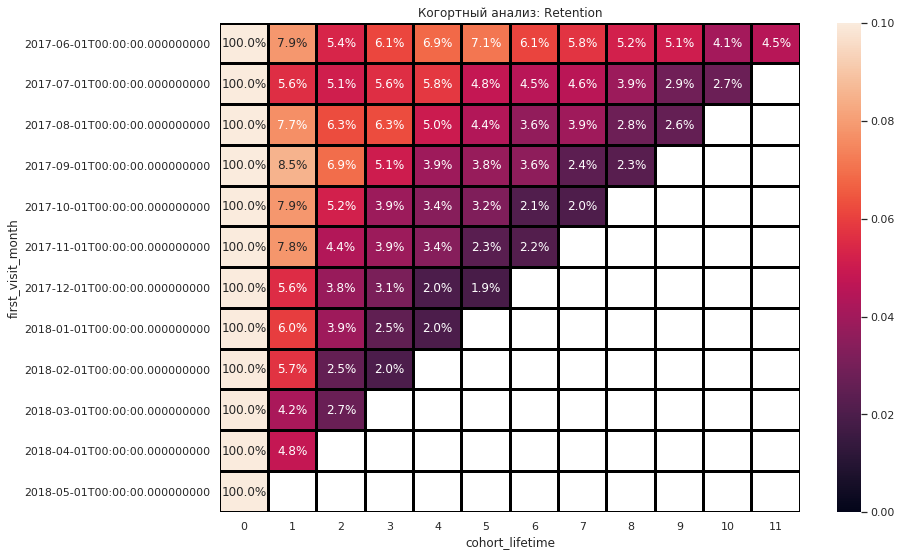

In [69]:
#посмтроим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когортный анализ: Retention')
sns.heatmap(retention_visits, annot=True, fmt='.1%', linewidths=2, linecolor='black', vmin= 0, vmax= 0.1)
#ax.set_yticklabels(retention_visits.index.date)
plt.show()

In [70]:
#посмотрим сводную таблицу уникальных пользователей 2017 и 2018 
visits.groupby(['year', 'month']).agg({'uid':['nunique', 'count']})

uid       
           nunique  count
year month               
2017 6       13259  16505
     7       14183  17828
     8       11631  14355
     9       18975  23907
     10      29692  37903
     11      32797  43969
     12      31557  41983
2018 1       28716  36939
     2       28749  37182
     3       27473  35677
     4       21008  26515
     5       20701  26635

#### Вывод  

Самый высокий Retention наблюдается у первой июньской когорты, особенно в 5-ый lifetime.  
В целом, по всем когортам наблюдается убывающий тренд. Только у июньской и июльской когорт наблюдается рост показателя в осенние месяцы. Это можно связать с фактором сезонности: как видно из таблицы выше, в октябре-ноябре-декабре наблюдалось значительное увеличение количества посетителей сайта. Это можно объяснить тем, что осень это пиковая точка ивент-событий(самый проседающий период это лето) и люди активно интересуются афишей.

<a id='3'><a/> 
## 3 Продажи.
[Назад к оглавлению](#back)

<a id='3.1'><a/> 
#### 3.1 Продажи. Когда люди начинают покупать.
[Назад к оглавлению](#back)

In [71]:
#посмотрим таблицу с информацией о заказах
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [72]:
#дата первой покупки
first_buy_date = orders.groupby(['uid'])['buy_ts'].min()
first_buy_date.name = 'first_buy_date'
first_buy_date.to_frame()

,first_buy_date
uid,
313578113262317,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00
2464366381792757,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00
...,...
18445147675727495770,2017-11-24 09:03:00
18445407535914413204,2017-09-22 23:55:00
18445601152732270159,2018-03-26 22:54:00


In [73]:
#дата первого визита
first_visit = visits.groupby('uid')['start_ts'].min()
first_visit.to_frame()

,start_ts
uid,
11863502262781,2018-03-01 17:27:00
49537067089222,2018-02-06 15:55:00
297729379853735,2017-06-07 18:47:00
313578113262317,2017-09-18 22:49:00
325320750514679,2017-09-30 14:29:00
...,...
18446403737806311543,2017-11-30 03:36:00
18446424184725333426,2017-12-06 20:32:00
18446556406699109058,2018-01-01 16:29:00


In [74]:
#первая покупка
first_buy = first_buy_date.to_frame()
first_visit_buy = first_buy.merge(first_visit, on='uid')
first_visit_buy

,first_buy_date,start_ts
uid,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...
18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00
18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00
18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00


In [75]:
#добавим столбец со временем покупки
first_visit_buy['time_to_buy_day'] = (first_visit_buy['first_buy_date'] - first_visit_buy['start_ts']).dt.days

In [76]:
first_visit_buy['time_to_buy_day'].value_counts()

0      26349
1       1011
2        563
3        434
4        324
       ...  
348        1
346        1
325        1
315        1
312        1
Name: time_to_buy_day, Length: 345, dtype: int64

In [77]:
26363 / len(first_visit_buy) * 100

72.20959215535895

Text(0, 0.5, 'Количество сессий')

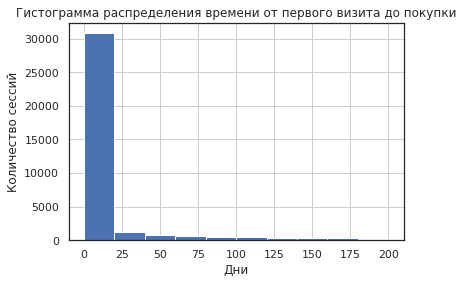

In [78]:
first_visit_buy['time_to_buy_day'].hist(range=(0,200))
plt.title('Гистограмма распределения времени от первого визита до покупки')
plt.xlabel('Дни')
plt.ylabel('Количество сессий')

In [79]:
#медианное значение времени покупки в днях
first_visit_buy['time_to_buy_day'].median()

0.0

Модальное значение времени от первого визита до первой покупки составляет 0 дней, т.е. пользователи совершают покупку в день своего захода на сайт. Здесь уже резонно в качестве среднего показателя брать моду, так как на него приходиться 72% от всех значений. Медианное значение тоже составляет 0 дней.

In [80]:
#добавим столбец со временем покупки в минутах
first_visit_buy['time_to_buy_minutes'] = (first_visit_buy['first_buy_date'] - first_visit_buy['start_ts']).dt.seconds / 60

In [81]:
first_visit_buy.head()

,first_buy_date,start_ts,time_to_buy_day,time_to_buy_minutes
uid,,,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106,1382.0
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0,0.0
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0,79.0
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0,1184.0
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0,0.0


In [82]:
#медианное значение времени покупки в минутах
first_visit_buy['time_to_buy_minutes'].median()

16.0

In [83]:
#мода времени покупки в минутах
first_visit_buy['time_to_buy_minutes'].mode()

0    1.0
dtype: float64

In [84]:
#посмотрим на данные по времени первой покупки в минутах
first_visit_buy['time_to_buy_minutes'].describe()

count    36509.000000
mean       249.216522
std        429.770861
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: time_to_buy_minutes, dtype: float64

Text(0.5, 1.0, 'Время в минутах от первого визита до покупки')

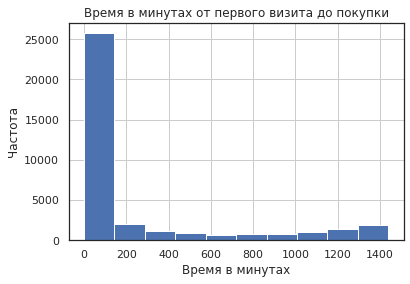

In [85]:
ax = first_visit_buy['time_to_buy_minutes'].hist()
ax.set_xlabel('Время в минутах')
ax.set_ylabel('Частота')
ax.set_title('Время в минутах от первого визита до покупки')

Люди покупают в среднем через 249 минут, в медианном через 16 минут, в моде через 1 минуту. 

In [86]:
#посмотрим на данные по устройствам
device_time_to_buy = first_visit_buy.merge(visits[['device', 'start_ts', 'uid']], on=['start_ts', 'uid'], how='left')
device_time_to_buy

,first_buy_date,uid,start_ts,time_to_buy_day,time_to_buy_minutes,device
0,2018-01-03 21:51:00,313578113262317,2017-09-18 22:49:00,106,1382.0,desktop
1,2017-06-03 10:13:00,1575281904278712,2017-06-03 10:13:00,0,0.0,touch
2,2017-10-11 18:33:00,2429014661409475,2017-10-11 17:14:00,0,79.0,desktop
3,2018-01-28 15:54:00,2464366381792757,2018-01-27 20:10:00,0,1184.0,desktop
4,2017-11-24 10:14:00,2551852515556206,2017-11-24 10:14:00,0,0.0,desktop
...,...,...,...,...,...,...
36504,2017-11-24 09:03:00,18445147675727495770,2017-08-20 13:30:00,95,1173.0,touch
36505,2017-09-22 23:55:00,18445407535914413204,2017-09-22 23:48:00,0,7.0,desktop
36506,2018-03-26 22:54:00,18445601152732270159,2017-08-07 11:51:00,231,663.0,desktop
36507,2018-02-18 19:34:00,18446156210226471712,2017-11-07 10:01:00,103,573.0,desktop


Text(0, 0.5, 'Количество сессий')

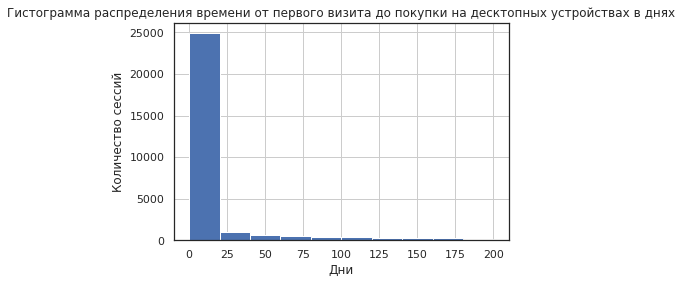

In [87]:
#построим гистограмму по десктопным устройствам в днях
device_time_to_buy[device_time_to_buy['device'] == 'desktop']['time_to_buy_day'].hist(range=(0,200))
plt.title('Гистограмма распределения времени от первого визита до покупки на десктопных устройствах в днях')
plt.xlabel('Дни')
plt.ylabel('Количество сессий')

Text(0, 0.5, 'Количество сессий')

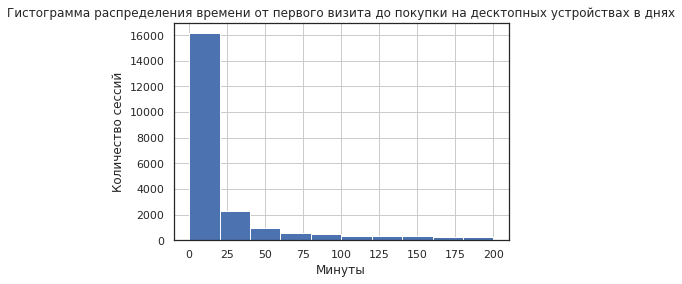

In [88]:
#построим гистограмму по десктопным устройствам в минутах
device_time_to_buy[device_time_to_buy['device'] == 'desktop']['time_to_buy_minutes'].hist(range=(0,200))
plt.title('Гистограмма распределения времени от первого визита до покупки на десктопных устройствах в днях')
plt.xlabel('Минуты')
plt.ylabel('Количество сессий')

In [89]:
print('Медианное время до совершения первой покупки на десктопном устройстве:', device_time_to_buy[device_time_to_buy['device'] == 'desktop']['time_to_buy_minutes'].median(), 'минут')

Медианное время до совершения первой покупки на десктопном устройстве: 14.0 минут


In [90]:
#посмотрим данные по дестопным устройствам в днях
device_time_to_buy[device_time_to_buy['device'] == 'desktop']['time_to_buy_day'].describe()

count    29198.000000
mean        15.863141
std         46.072707
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        363.000000
Name: time_to_buy_day, dtype: float64

In [91]:
#посмотрим данные по дестопным устройствам в минутах
device_time_to_buy[device_time_to_buy['device'] == 'desktop']['time_to_buy_minutes'].describe()

count    29198.000000
mean       233.568703
std        423.116182
min          0.000000
25%          4.000000
50%         14.000000
75%        193.000000
max       1439.000000
Name: time_to_buy_minutes, dtype: float64

Text(0, 0.5, 'Количество сессий')

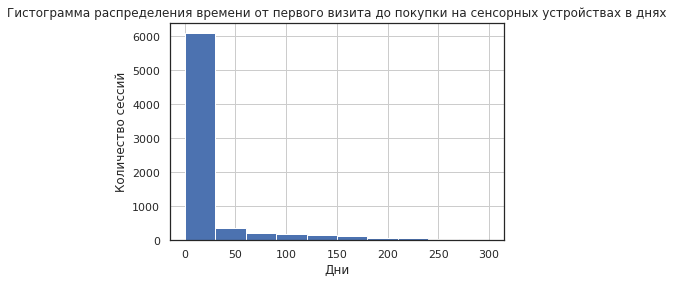

In [92]:
#построим гистограмму по сенсорным устройствам по дням
device_time_to_buy[device_time_to_buy['device'] == 'touch']['time_to_buy_day'].hist(range=(0,300))
plt.title('Гистограмма распределения времени от первого визита до покупки на сенсорных устройствах в днях')
plt.xlabel('Дни')
plt.ylabel('Количество сессий')

Text(0, 0.5, 'Количество сессий')

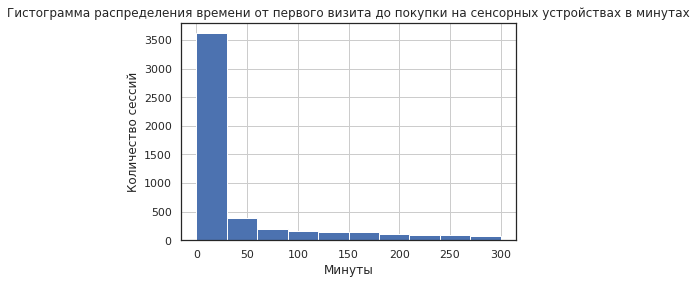

In [93]:
#построим гистограмму по сенсорным устройствам в минутах
device_time_to_buy[device_time_to_buy['device'] == 'touch']['time_to_buy_minutes'].hist(range=(0,300))
plt.title('Гистограмма распределения времени от первого визита до покупки на сенсорных устройствах в минутах')
plt.xlabel('Минуты')
plt.ylabel('Количество сессий')

In [94]:
print('Медианное время до совершения первой покупки на сенсорном устройстве:', device_time_to_buy[device_time_to_buy['device'] == 'touch']['time_to_buy_minutes'].median(), 'минут')

Медианное время до совершения первой покупки на сенсорном устройстве: 31.0 минут


In [95]:
#посмотрим данные по тач устройствам в днях
device_time_to_buy[device_time_to_buy['device'] == 'touch']['time_to_buy_day'].describe()

count    7311.000000
mean       20.262344
std        50.297445
min         0.000000
25%         0.000000
50%         0.000000
75%         6.000000
max       362.000000
Name: time_to_buy_day, dtype: float64

In [96]:
#посмотрим данные по тач устройствам в минутах
device_time_to_buy[device_time_to_buy['device'] == 'touch']['time_to_buy_minutes'].describe()

count    7311.000000
mean      311.709342
std       450.015258
min         0.000000
25%         4.000000
50%        31.000000
75%       539.500000
max      1439.000000
Name: time_to_buy_minutes, dtype: float64

#### Вывод  

Время между визитом и покупкой составляет 0 дней (т.е. совершается в тот же самый день) независимо от платформы, с которой покупатель зашел на сайт.  

Люди покупают в среднем через 249 минут, в медианном через 16 минут, в моде через 1 минуту. На десктопных устройствах среднее время до совршения покупки составляет 14 минут, в то время как на сенсорном 31 минуту. Это может говорить о том, что людям удбнее совершать покупки с десктопной версии.

<a id='3.2'><a/> 
#### 3.2 Продажи. Сколько раз покупают за период.
[Назад к оглавлению](#back)

In [97]:
#посмотрим таблицу с данными о заказах
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [98]:
#соединим таблицы
orders = orders.join(first_buy_date,on='uid')
orders.sample(10)

,buy_ts,revenue,uid,first_buy_date
50134,2018-05-31 13:32:00,4.89,16674220541096562302,2017-06-01 17:33:00
41222,2018-03-22 19:19:00,2.75,18357097004613734745,2018-03-22 19:19:00
45770,2018-04-27 19:39:00,0.43,6805379653434147750,2018-04-27 19:39:00
141,2017-06-02 12:58:00,2.32,16834079793805208235,2017-06-02 12:58:00
46975,2018-05-11 13:37:00,3.67,10445756469780166514,2018-05-11 13:37:00
12218,2017-10-11 17:02:00,1.34,390448136515412133,2017-10-07 15:23:00
14110,2017-10-23 00:20:00,32.63,5101793808405359710,2017-10-22 11:04:00
3321,2017-07-14 13:47:00,0.18,11216674254954527647,2017-07-14 13:47:00
37091,2018-02-26 19:25:00,4.03,9611579669297201174,2017-10-23 19:27:00
39550,2018-03-12 12:22:00,0.36,2396438564891815249,2018-03-12 12:22:00


In [99]:
#добавим столбцы с месяцем и первым месяцем покупки
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_buy_month'] = orders['first_buy_date'].astype('datetime64[M]')

In [100]:
#посмотрим рандомную выборку из таблицы
orders.sample(5)

,buy_ts,revenue,uid,first_buy_date,buy_month,first_buy_month
27106,2017-12-30 07:09:00,1.22,17895474374682685162,2017-12-30 07:09:00,2017-12-01,2017-12-01
12652,2017-10-13 22:54:00,2.32,9398193237476021260,2017-10-13 22:54:00,2017-10-01,2017-10-01
43616,2018-04-09 21:44:00,5.50,3252531839147569035,2018-04-09 21:44:00,2018-04-01,2018-04-01
32052,2018-01-31 13:56:00,2.62,1983520863775199755,2018-01-31 13:56:00,2018-01-01,2018-01-01
30758,2018-01-24 08:30:00,1.22,1771375665831381311,2018-01-24 07:56:00,2018-01-01,2018-01-01


In [101]:
#найдем lifetime когорт
orders['cohort_lifetime'] = orders['buy_month'] - orders['first_buy_month']
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1,'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')

In [102]:
orders.sample(5)

,buy_ts,revenue,uid,first_buy_date,buy_month,first_buy_month,cohort_lifetime
29669,2018-01-16 18:18:00,2.44,17897025075074999883,2018-01-16 18:18:00,2018-01-01,2018-01-01,0
40517,2018-03-19 00:43:00,6.11,13923438976101236583,2018-03-19 00:43:00,2018-03-01,2018-03-01,0
24388,2017-12-16 10:12:00,3.67,10277737853311979603,2017-12-16 10:12:00,2017-12-01,2017-12-01,0
13695,2017-10-20 11:17:00,4.28,348238000252671115,2017-10-02 20:01:00,2017-10-01,2017-10-01,0
25334,2017-12-22 00:28:00,4.44,3766633659180381550,2017-12-22 00:28:00,2017-12-01,2017-12-01,0


In [103]:
#получим когорты
cohorts = orders.groupby(['first_buy_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_buy_month,cohort_lifetime,uid
0,2017-06-01,0,2022
1,2017-06-01,1,61
2,2017-06-01,2,50
3,2017-06-01,3,54
4,2017-06-01,4,87
...,...,...,...
74,2018-03-01,2,58
75,2018-04-01,0,2274
76,2018-04-01,1,69
77,2018-05-01,0,2986


In [104]:
initial_buyer_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_buy_month','uid']]
initial_buyer_count

,first_buy_month,uid
0,2017-06-01,2022
12,2017-07-01,1922
23,2017-08-01,1369
33,2017-09-01,2579
42,2017-10-01,4340
50,2017-11-01,4078
57,2017-12-01,4380
63,2018-01-01,3373
68,2018-02-01,3651
72,2018-03-01,3534


In [105]:
#переименуем колонку
initial_buyer_count = initial_buyer_count.rename(columns={'uid':'cohort_buyers'})

In [106]:
#соединим таблицы
cohorts = cohorts.merge(initial_buyer_count, on='first_buy_month')
cohorts

,first_buy_month,cohort_lifetime,uid,cohort_buyers
0,2017-06-01,0,2022,2022
1,2017-06-01,1,61,2022
2,2017-06-01,2,50,2022
3,2017-06-01,3,54,2022
4,2017-06-01,4,87,2022
...,...,...,...,...
74,2018-03-01,2,58,3534
75,2018-04-01,0,2274,2274
76,2018-04-01,1,69,2274
77,2018-05-01,0,2986,2986


In [107]:
#посчитаем retention и добавим новый столбец
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_buyers']

In [108]:
cohorts.head(10)

,first_buy_month,cohort_lifetime,uid,cohort_buyers,retention
0,2017-06-01,0,2022,2022,1.000000
1,2017-06-01,1,61,2022,0.030168
2,2017-06-01,2,50,2022,0.024728
3,2017-06-01,3,54,2022,0.026706
4,2017-06-01,4,87,2022,0.043027
5,2017-06-01,5,67,2022,0.033136
6,2017-06-01,6,61,2022,0.030168
7,2017-06-01,7,47,2022,0.023244
8,2017-06-01,8,58,2022,0.028684
9,2017-06-01,9,45,2022,0.022255


In [109]:
#построим сводную таблицу по retention
retention_pivot = cohorts.pivot_table(index='first_buy_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1.0,0.030168,0.024728,0.026706,0.043027,0.033136,0.030168,0.023244,0.028684,0.022255,0.022255,0.026212
2017-07-01,1.0,0.027055,0.029657,0.033299,0.025494,0.019771,0.018730,0.020291,0.021852,0.011446,0.013528,NaN
2017-08-01,1.0,0.042367,0.038714,0.032140,0.029218,0.023375,0.021914,0.032140,0.013879,0.022644,NaN,NaN
2017-09-01,1.0,0.050019,0.038387,0.028693,0.020163,0.024816,0.025591,0.014347,0.016673,NaN,NaN,NaN
2017-10-01,1.0,0.047465,0.028341,0.021198,0.021429,0.016590,0.012903,0.015438,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.054193,0.029426,0.025993,0.019617,0.011770,0.015204,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.033333,0.023516,0.022146,0.011416,0.014384,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.033798,0.024607,0.012748,0.013341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.032320,0.015886,0.010682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


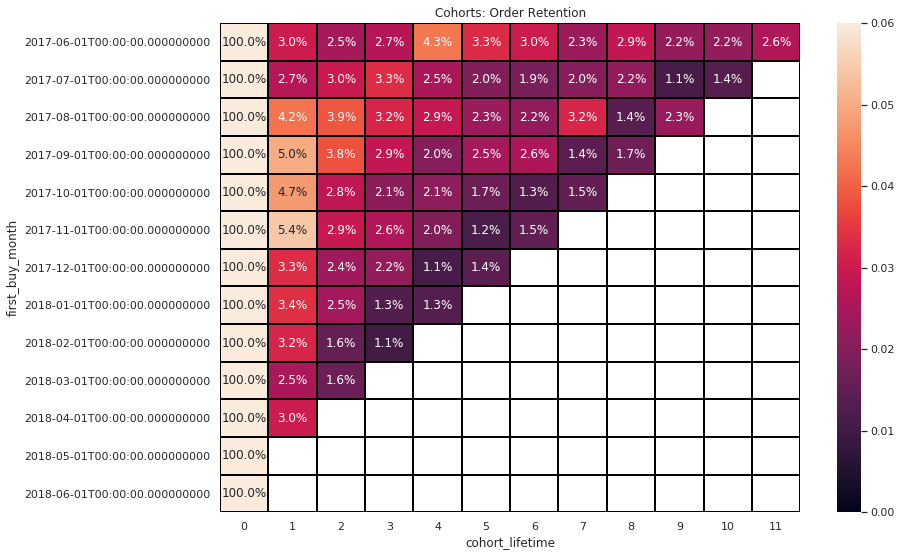

In [110]:
#визуализируем тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Order Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black', vmin= 0, vmax= 0.06)

Retention в течение всего периода очень низкий. Рост показателя Retention наблюдаются в летних когортах к октябрю, в целом же показатель падает с каждым последующим месяцем.

Ситуация, аналогичная с retention'ом по посетителям сайта: тройка октябрь-ноябрь-декабрь характеризуется резким ростом в количестве заказов относительно других месяцев.

In [111]:
#найдем количество заказов 
order_per_person = orders.groupby('buy_month').agg({'uid':['nunique', 'count']})
order_per_person.columns = ['amount_of_buyers', 'amount_of_orders']
order_per_person

,amount_of_buyers,amount_of_orders
buy_month,,
2017-06-01,2022,2353
2017-07-01,1983,2362
2017-08-01,1471,1803
2017-09-01,2748,3383
2017-10-01,4673,5677
2017-11-01,4543,5644
2017-12-01,4937,6206
2018-01-01,3898,4721
2018-02-01,4258,5280


Text(0, 0.5, 'Количество')

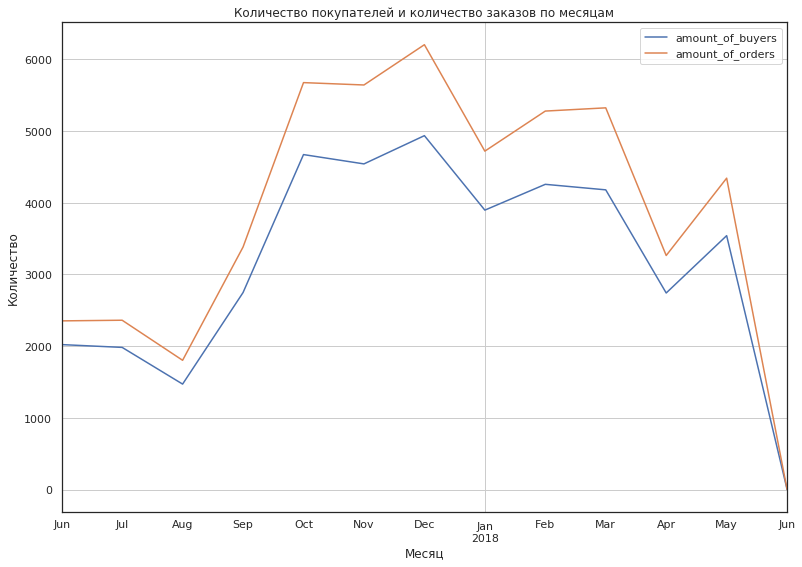

In [112]:
#построим график по количеству покупателей и количеству заказов
order_per_person.plot(kind='line', grid=True, figsize = (13, 9), title ='Количество покупателей и количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')

Пиковое значение приходится на конец ноября - начало декабря. Так же есть скачки в октябре и марте.

In [113]:
#добавим новый столбец
order_per_person['order_per_person'] = order_per_person['amount_of_orders'] / order_per_person['amount_of_buyers']
order_per_person

,amount_of_buyers,amount_of_orders,order_per_person
buy_month,,,
2017-06-01,2022,2353,1.163699
2017-07-01,1983,2362,1.191125
2017-08-01,1471,1803,1.225697
2017-09-01,2748,3383,1.231077
2017-10-01,4673,5677,1.214851
2017-11-01,4543,5644,1.242351
2017-12-01,4937,6206,1.257039
2018-01-01,3898,4721,1.211134
2018-02-01,4258,5280,1.240019


In [114]:
#посмотрим среднее значение заказов на человека
order_per_person['order_per_person'].mean()

1.205213272283044

В среднем за период одним покупателем совершается 1.2 покупки. Это означает, что, как правило, большинство покупателей не совершают повторную покупку в этот же месяц.

### Сколько покупают за день, неделю, месяц

In [115]:
#объединим таблицу
orders_and_visits = orders.merge(first_buy, on='uid')
orders_and_visits.head()

,buy_ts,revenue,uid,first_buy_date_x,buy_month,first_buy_month,cohort_lifetime,first_buy_date_y
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,2017-06-01 07:58:00


In [116]:
#добавим столбцы
orders_and_visits['buy_date'] = orders_and_visits['buy_ts'].dt.date
orders_and_visits['buy_week'] = orders_and_visits['buy_ts'].dt.week
orders_and_visits['buy_month'] = orders_and_visits['buy_ts'].dt.month

In [117]:
purchases_per_day = orders_and_visits.groupby('buy_date')['uid'].count()
purchases_per_week = orders_and_visits.groupby(['buy_week'])['uid'].count()
purchases_per_month = orders_and_visits.groupby(['buy_month'])['uid'].count()

In [118]:
#создадим новый датафрейм
orders_count = pd.DataFrame()

In [119]:
#добавим в него столбцы с данными
orders_count['per_day'] = purchases_per_day.describe()
orders_count['per_week'] = purchases_per_week.describe()
orders_count['per_month'] = purchases_per_month.describe()

In [120]:
orders_count.head(8)

,per_day,per_week,per_month
count,364.000000,52.000000,12.00000
mean,138.362637,968.538462,4197.00000
std,76.804287,397.228312,1510.21004
min,1.000000,313.000000,1803.00000
25%,82.750000,657.000000,3039.25000
50%,136.000000,997.500000,4532.50000
75%,177.000000,1270.500000,5404.75000
max,814.000000,1894.000000,6206.00000


<a id='3.3'><a/> 
#### 3.3 Продажи. Какой средний чек.
[Назад к оглавлению](#back)

In [121]:
#посмотрим информацию по выручке 
orders_and_visits['revenue'].describe()

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [122]:
#посмотрим моду
orders_and_visits['revenue'].mode()

0    1.83
dtype: float64

In [123]:
#выделим дату
orders_and_visits['buy_month'] = orders_and_visits['buy_ts'].astype('datetime64[M]')

In [124]:
#найдем среднюю помесячну выручку 
mean_purchase_by_month = orders_and_visits.groupby('buy_month').agg({'revenue': 'mean'})

In [125]:
mean_purchase_by_month

,revenue
buy_month,
2017-06-01,4.061832
2017-07-01,5.308836
2017-08-01,4.857892
2017-09-01,5.422852
2017-10-01,4.930016
2017-11-01,4.796231
2017-12-01,5.863455
2018-01-01,4.112927
2018-02-01,4.841011


Text(0, 0.5, 'Выручка')

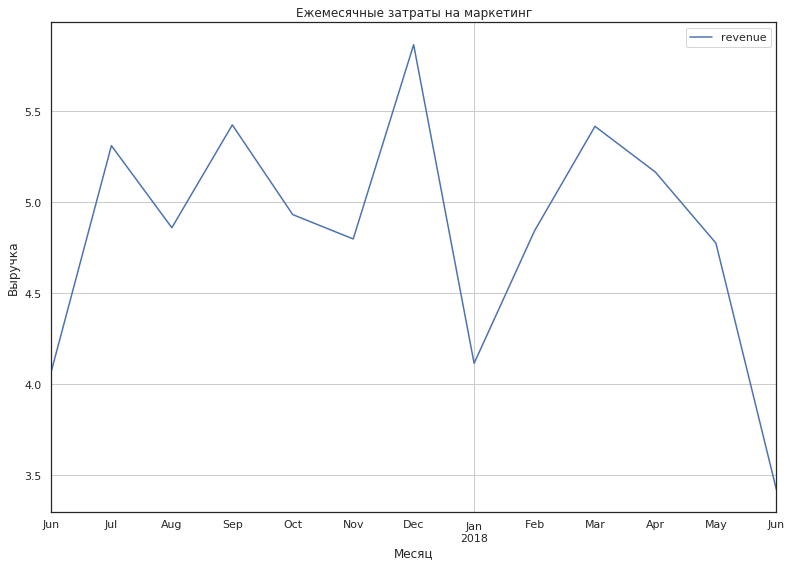

In [126]:
mean_purchase_by_month.plot(kind='line', grid=True, figsize = (13, 9), title ='Ежемесячные затраты на маркетинг')
plt.xlabel('Месяц')
plt.ylabel('Выручка')

Средний чек бывает от 4 до 6к, мода равняется 1.8.

In [127]:
revenue = orders.groupby(['first_buy_month','buy_month']).agg({'revenue':'sum','uid':'count'})
revenue

revenue   uid
first_buy_month buy_month                 
2017-06-01      2017-06-01   9557.49  2353
                2017-07-01    981.82   177
                2017-08-01    885.34   171
                2017-09-01   1931.30   224
                2017-10-01   2068.58   291
...                              ...   ...
2018-03-01      2018-05-01   1114.87   176
2018-04-01      2018-04-01  10600.69  2487
                2018-05-01   1209.92   195
2018-05-01      2018-05-01  13925.76  3247
2018-06-01      2018-06-01      3.42     1

[79 rows x 2 columns]

In [128]:
revenue['revenue_per_order'] = revenue['revenue'] / revenue['uid']
revenue

revenue   uid  revenue_per_order
first_buy_month buy_month                                    
2017-06-01      2017-06-01   9557.49  2353           4.061832
                2017-07-01    981.82   177           5.547006
                2017-08-01    885.34   171           5.177427
                2017-09-01   1931.30   224           8.621875
                2017-10-01   2068.58   291           7.108522
...                              ...   ...                ...
2018-03-01      2018-05-01   1114.87   176           6.334489
2018-04-01      2018-04-01  10600.69  2487           4.262441
                2018-05-01   1209.92   195           6.204718
2018-05-01      2018-05-01  13925.76  3247           4.288808
2018-06-01      2018-06-01      3.42     1           3.420000

[79 rows x 3 columns]

In [129]:
revenue.pivot_table(index='first_buy_month', columns='buy_month', values='revenue_per_order', aggfunc='mean')

buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_buy_month,,,,,,,,,,,,,
2017-06-01,4.061832,5.547006,5.177427,8.621875,7.108522,6.825321,6.986545,6.761839,5.279009,8.009869,12.038125,6.042093,NaN
2017-07-01,NaN,5.289542,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302,NaN
2017-08-01,NaN,NaN,4.718557,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478,NaN
2017-09-01,NaN,NaN,NaN,4.970498,13.231606,8.380750,62.570244,15.430448,15.321835,16.923832,11.206607,7.785574,NaN
2017-10-01,NaN,NaN,NaN,NaN,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.384218,4.170103,4.474670,6.284976,4.467778,3.726780,4.598235,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.114869,4.226741,20.072772,26.084358,15.948488,14.111048,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.687417,4.438482,6.454969,7.524844,2.711282,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.707171,4.576486,3.453735,3.867143,NaN


In [130]:
revenue = revenue.reset_index()
revenue['cohort_lifetime'] = revenue['buy_month'] - revenue['first_buy_month']
revenue

,first_buy_month,buy_month,revenue,uid,revenue_per_order,cohort_lifetime
0,2017-06-01,2017-06-01,9557.49,2353,4.061832,0 days
1,2017-06-01,2017-07-01,981.82,177,5.547006,30 days
2,2017-06-01,2017-08-01,885.34,171,5.177427,61 days
3,2017-06-01,2017-09-01,1931.30,224,8.621875,92 days
4,2017-06-01,2017-10-01,2068.58,291,7.108522,122 days
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,176,6.334489,61 days
75,2018-04-01,2018-04-01,10600.69,2487,4.262441,0 days
76,2018-04-01,2018-05-01,1209.92,195,6.204718,30 days
77,2018-05-01,2018-05-01,13925.76,3247,4.288808,0 days


In [131]:
revenue['cohort_lifetime'] = revenue['cohort_lifetime'] / np.timedelta64(1,'M')
revenue['cohort_lifetime'] = revenue['cohort_lifetime'].round().astype('int')
revenue

,first_buy_month,buy_month,revenue,uid,revenue_per_order,cohort_lifetime
0,2017-06-01,2017-06-01,9557.49,2353,4.061832,0
1,2017-06-01,2017-07-01,981.82,177,5.547006,1
2,2017-06-01,2017-08-01,885.34,171,5.177427,2
3,2017-06-01,2017-09-01,1931.30,224,8.621875,3
4,2017-06-01,2017-10-01,2068.58,291,7.108522,4
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,176,6.334489,2
75,2018-04-01,2018-04-01,10600.69,2487,4.262441,0
76,2018-04-01,2018-05-01,1209.92,195,6.204718,1
77,2018-05-01,2018-05-01,13925.76,3247,4.288808,0


In [132]:
revenue_pivot = revenue.pivot_table(index='first_buy_month', columns='cohort_lifetime', values='revenue_per_order', aggfunc='mean')
revenue_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.061832,5.547006,5.177427,8.621875,7.108522,6.825321,6.986545,6.761839,5.279009,8.009869,12.038125,6.042093
2017-07-01,5.289542,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302,NaN
2017-08-01,4.718557,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478,NaN,NaN
2017-09-01,4.970498,13.231606,8.380750,62.570244,15.430448,15.321835,16.923832,11.206607,7.785574,NaN,NaN,NaN
2017-10-01,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120,NaN,NaN,NaN,NaN
2017-11-01,4.384218,4.170103,4.474670,6.284976,4.467778,3.726780,4.598235,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.114869,4.226741,20.072772,26.084358,15.948488,14.111048,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.687417,4.438482,6.454969,7.524844,2.711282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.707171,4.576486,3.453735,3.867143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


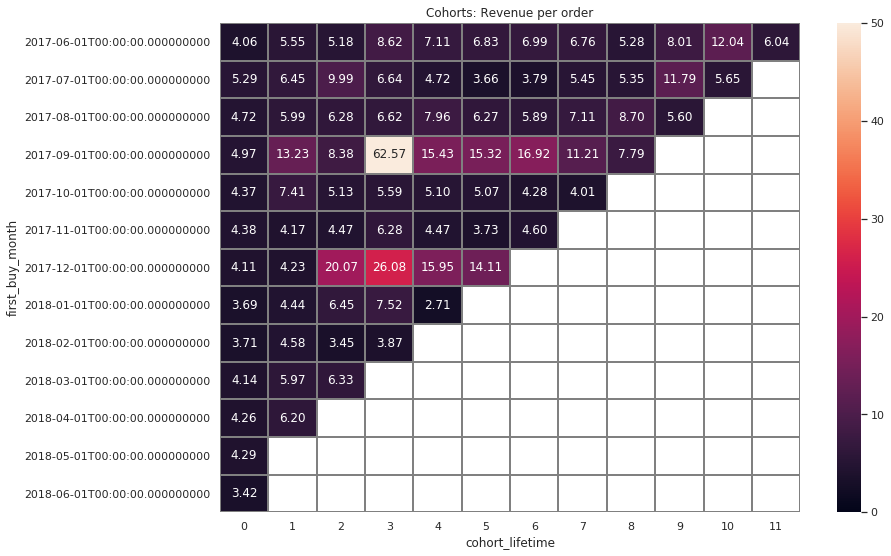

In [133]:
#посмтроим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Revenue per order')
ax.set_yticklabels(revenue_pivot.index.date)
sns.heatmap(revenue_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin = 0, vmax = 50)

In [134]:
print('Медианное значение выручки', orders_and_visits['revenue'].median())
print('Среднее значение выручки', orders_and_visits['revenue'].mean())
print('Максимальное значение выручки', orders_and_visits['revenue'].max())

Медианное значение выручки 2.5
Среднее значение выручки 5.004709713287269
Максимальное значение выручки 2633.28


In [135]:
#посмотрим на покупку на неординарно большую сумму
orders_and_visits[orders_and_visits['revenue'] == 2633.28]

,buy_ts,revenue,uid,first_buy_date_x,buy_month,first_buy_month,cohort_lifetime,first_buy_date_y,buy_date,buy_week
11718,2017-12-10 20:17:00,2633.28,5539673724080479777,2017-09-20 19:55:00,2017-12-01,2017-09-01,3,2017-09-20 19:55:00,2017-12-10,49


#### Вывод  

Средний чек заказа ведёт себя нестабильно. Интерес представля когорты cентября и декабря, так как там наблюдается значительный скачок среднего чека вверх после первого месяца покупки.

В сентябрьской когорте на 3-ий месяц использования (в декабре) средний чек составил 62.57 условных единиц. Объясняется это тем, что максимальное значение покупки в 2633.28 было совершено как раз таки пользователем из сентябрьской когорты.

<a id='3.4'><a/> 
#### 3.4 Продажи. Сколько денег приносят (LTV).
[Назад к оглавлению](#back)

In [136]:
orders.head()

,buy_ts,revenue,uid,first_buy_date,buy_month,first_buy_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0


In [137]:
# определяем источник пользователя
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

In [138]:
# соединяем первые покупки и источники 
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})

In [139]:
ltv = payers.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1, 'M')).round().astype(int)

orders_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'count').fillna(0)
buyers_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)

In [140]:
# добавляем размеры когорт (источники) и делим на них
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv = ltv.merge(cohort_sizes, on = 'source_id')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
ltv

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.162562,7.158242,7.899330,8.546599,9.038657,9.260666,9.535694,9.877079,10.201813,10.461689,10.568498,10.684565,10.735687
2,6.777830,8.065415,9.726654,11.263685,11.910728,12.495492,12.732312,12.959469,13.182638,13.244893,13.358424,13.391881,13.395264
3,4.480346,4.732079,4.868622,5.011104,5.086006,5.125526,5.149953,5.176635,5.195330,5.200457,5.205682,5.206817,5.207914
4,4.584762,4.738128,4.852278,4.948617,5.068362,5.226563,5.342363,5.391025,5.410340,5.448244,5.502627,5.505380,5.506685
5,4.909883,5.114191,5.469974,6.836748,7.072747,7.246335,7.365203,7.454998,7.515129,7.576270,7.582746,7.592303,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.880901,4.167390,4.408024,4.678888,4.788189,4.935588,5.059127,5.126608,5.244430,5.284972,5.293566,5.293566,5.293566
10,3.168900,3.232298,3.259601,3.307536,3.321575,3.324220,3.337747,3.348387,3.351145,3.353677,3.353677,3.353677,3.353677


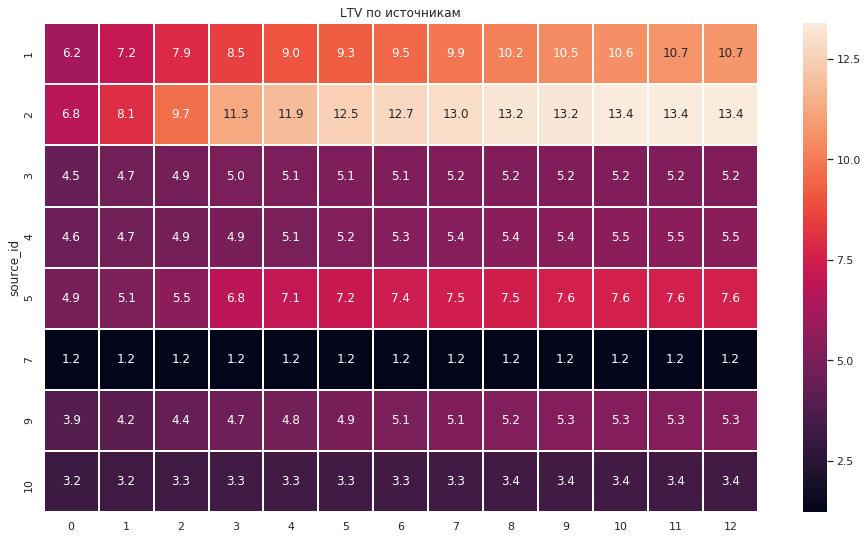

In [141]:
#посмтроим тепловую карту
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('LTV по источникам')
ax = sns.heatmap(ltv, annot=True, fmt='.1f', linewidths=1, linecolor='white')
plt.show()

Мы видим, что самый высокий LTV у источника номер 2 и у источника номер 1. Так же неплохо себя показывает источник номер 5.

Теперь посмотрим LTV по когортам.

In [142]:
#найдем первый месяц заказа
first_orders = orders.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_buy_month']
first_orders.head()

,uid,first_buy_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [143]:
#посмотрим количество покупателей 
initial_buyer_count

,first_buy_month,cohort_buyers
0,2017-06-01,2022
12,2017-07-01,1922
23,2017-08-01,1369
33,2017-09-01,2579
42,2017-10-01,4340
50,2017-11-01,4078
57,2017-12-01,4380
63,2018-01-01,3373
68,2018-02-01,3651
72,2018-03-01,3534


In [144]:
ltv_cohorts = orders.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
ltv_cohorts

,first_buy_month,buy_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [145]:
report = pd.merge(ltv_cohorts, initial_buyer_count, on='first_buy_month')
report

,first_buy_month,buy_month,revenue,cohort_buyers
0,2017-06-01,2017-06-01,9557.49,2022
1,2017-06-01,2017-07-01,981.82,2022
2,2017-06-01,2017-08-01,885.34,2022
3,2017-06-01,2017-09-01,1931.30,2022
4,2017-06-01,2017-10-01,2068.58,2022
...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3534
75,2018-04-01,2018-04-01,10600.69,2274
76,2018-04-01,2018-05-01,1209.92,2274
77,2018-05-01,2018-05-01,13925.76,2986


In [146]:
#опреледим lifetime
report['lifetime'] = (report['buy_month'] - report['first_buy_month']) / np.timedelta64(1, 'M')
report['lifetime'] = report['lifetime'].round().astype('int')

In [147]:
# рассчитаем LTV как отношение валовой прибыли за месяц к размеру соответствующей когорты
margin_rate = 1
report['ltv'] = report['revenue'] * margin_rate / report['cohort_buyers']

In [148]:
# построим сводную таблицу и посчитаем накопленную сумму
ltv_pivot = report.pivot_table(index='first_buy_month', columns='lifetime', values='ltv').cumsum(axis=1)
ltv_pivot.loc['mean'] = ltv_pivot.mean()
ltv_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01 00:00:00,4.726751,5.212319,5.650173,6.605317,7.628353,8.364219,9.314416,9.896296,10.449782,11.055870,11.627413,11.884397
2017-07-01 00:00:00,6.013345,6.348730,6.972586,7.331748,7.508632,7.664761,7.785031,7.926925,8.088241,8.235463,8.391217,NaN
2017-08-01 00:00:00,5.280373,5.752710,6.211527,6.603090,7.097502,7.381249,7.592067,7.997370,8.289795,8.477911,NaN,NaN
2017-09-01 00:00:00,5.648907,6.767359,7.287297,11.266173,11.667041,12.314610,13.016762,13.260101,13.444250,NaN,NaN,NaN
2017-10-01 00:00:00,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01 00:00:00,5.159358,5.558166,5.757869,6.083060,6.230964,6.284882,6.399895,NaN,NaN,NaN,NaN,NaN
2017-12-01 00:00:00,4.742434,5.002986,5.928717,6.994721,7.307865,7.646144,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:00:00,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 00:00:00,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


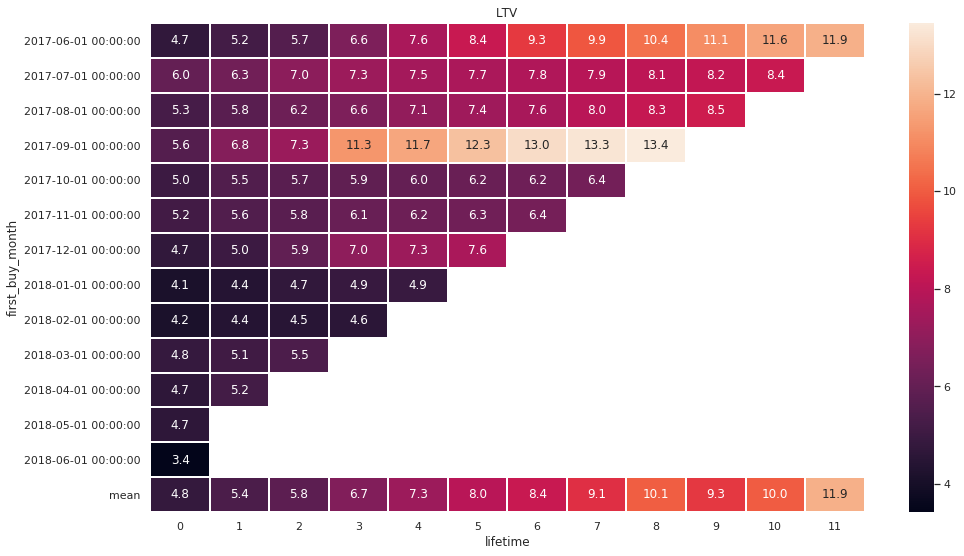

In [149]:
#посмтроим тепловую карту
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('LTV')
ax = sns.heatmap(ltv_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='white')
#ax.set_yticklabels(ltv_pivot.index.date)
plt.show()

#### Вывод  

Самый высокий LTV у сентябрьской когорты. Но не стоит забывать, что в сентябре была сделана покупка на очень крупную сумму (2633.28), которая сильно выбивается и очевидно влияет на рузльтат. Как следствие, наиболее высокий LTV у июньской когорты. Она существует дольше всех, но тем не менее, судя по ежемесячному приросту LTV едва ли другие когорты смогут достичь того же показателя.

<a id='4'><a/> 
## 4 Маркетинг
[Назад к оглавлению](#back)

<a id='4.1'><a/> 
#### 4.1 Маркетинг. Сколько денег потратили. Всего / на каждый источник / по времени.
[Назад к оглавлению](#back)

In [150]:
#посмотрим таблицу с информацией о затратах на маркетинг
costs.sample(5)

,source_id,dt,costs
1862,9,2017-07-17,20.90
1188,4,2017-09-08,307.03
843,3,2017-09-26,531.85
910,3,2017-12-02,425.38
340,1,2018-05-09,28.16


In [151]:
print('Общая сумма затрат на маркетинг:', costs['costs'].sum())

Общая сумма затрат на маркетинг: 329131.62


In [152]:
#посмотрим затраты по источникам
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()

In [153]:
#добавим столбец со значениями в процентах
costs_by_source['in_percents'] = costs_by_source['costs'] / 329131.62 * 100

In [154]:
costs_by_source.sort_values('in_percents', ascending = False)

,source_id,costs,in_percents
2,3,141321.63,42.937725
3,4,61073.60,18.555981
4,5,51757.10,15.725350
1,2,42806.04,13.005751
0,1,20833.27,6.329769
6,10,5822.49,1.769046
5,9,5517.49,1.676378


Text(0, 0.5, 'Затраты')

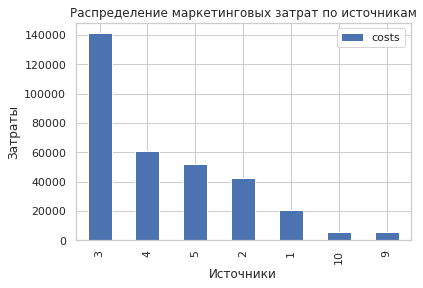

In [155]:
#построим диаграмму
costs_by_source.sort_values(by='costs', ascending = False).plot(kind='bar', x='source_id', y='costs', title ='Распределение маркетинговых затрат по источникам')
plt.xlabel('Источники')
plt.ylabel('Затраты')

Наибольшие затраты на источник 3. Так же значительная часть средств тратится на источники 4, 5 и 2.

In [156]:
#выделим месяцы
costs['cost_month'] = costs['dt'].astype('datetime64[M]')

In [157]:
#посчитаем сумму по месяцам
costs.groupby('cost_month')['costs'].sum()

cost_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

Text(0, 0.5, 'Затраты')

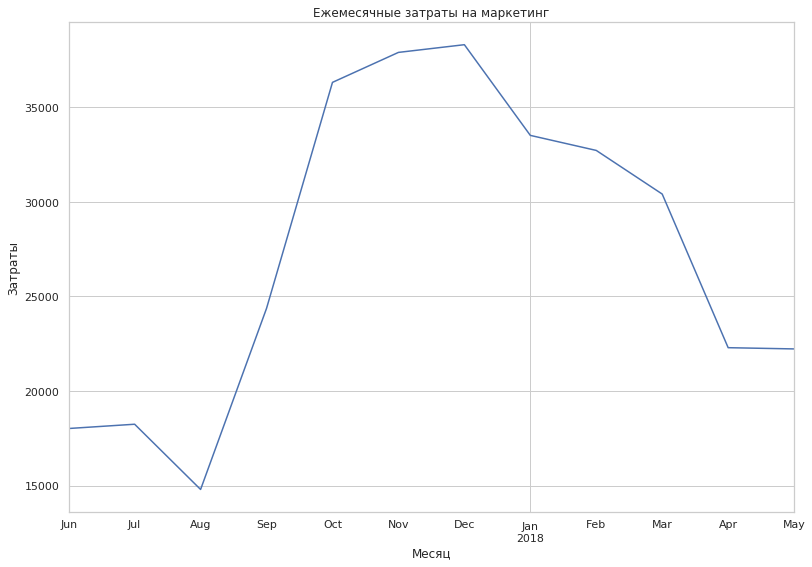

In [158]:
costs.groupby('cost_month')['costs'].sum().plot(kind='line', grid=True, figsize = (13, 9), title ='Ежемесячные затраты на маркетинг')
plt.xlabel('Месяц')
plt.ylabel('Затраты')

In [159]:
#посчитаем каждый месяц по источникам
costs_pivot_table = costs.pivot_table(index='cost_month', columns='source_id', values='costs', aggfunc='sum')
costs_pivot_table

source_id,1,2,3,4,5,9,10
cost_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


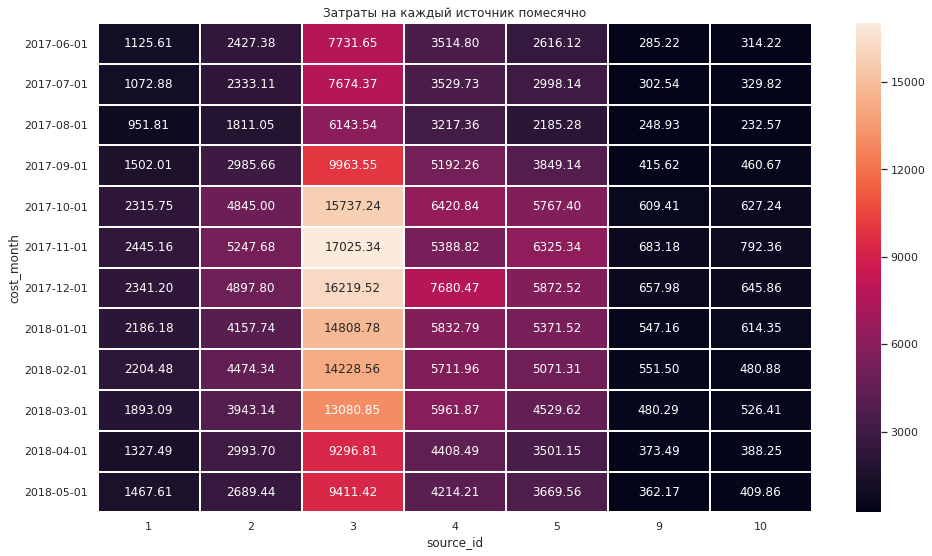

In [160]:
#посмтроим тепловую карту
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('Затраты на каждый источник помесячно')
ax = sns.heatmap(costs_pivot_table, annot=True, fmt='.2f', linewidths=1, linecolor='white')
ax.set_yticklabels(costs_pivot_table.index.date)
plt.show()

Тут тк же мы вмдим, что наибольшие затраты идут на 3 источник.

<a id='4.2'><a/> 
#### 4.2 Маркетинг. Сколько стоило привлечение одного покупателя из каждого источника.
[Назад к оглавлению](#back)

In [161]:
visits.head()

,device,source_id,ts_date,start_ts,end_ts,uid,year,month,month_name,week_number,day_number,day_of_week_number,day_of_week,session_duration_minutes,first_visit,first_visit_month,visit_month,cohort_lifetime
0,touch,4,2017-12-20,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,2017,12,December,51,20,2,Wednesday,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2,2018-02-19,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2018,2,February,8,19,0,Monday,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,5,2017-07-01,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,2017,7,July,26,1,5,Saturday,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,9,2018-05-20,2018-05-20 10:59:00,2018-05-20 11:23:00,16174680259334210214,2018,5,May,20,20,6,Sunday,24.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,4,2018-03-09,2018-03-09 20:05:00,2018-03-09 20:33:00,16174680259334210214,2018,3,March,10,9,4,Friday,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01,0


In [162]:
#посмотрим, есть ли пользователи, совершавшие переходы из разных источников
many_visits = visits['uid'].value_counts().reset_index() 
many_visits

,index,uid
0,12869801667763685675,893
1,3263486045884611639,615
2,11255648391090536411,551
3,17030528792926543083,357
4,8056418121947262981,343
...,...,...
228164,13023238853810096243,1
228165,13275209559615110952,1
228166,10451189761655280393,1
228167,11370115024582961201,1


In [163]:
#для примера глянем на пользователей, совершивших 5 переходов с разных источников
many_visits[many_visits['uid'] == 5]

,index,uid
4378,2187729065808233520,5
4379,5233168625601252316,5
4380,3407951284720693171,5
4381,17023756410330932635,5
4382,15520865065339542594,5
...,...,...
6655,732593076938593657,5
6656,13526589330692760814,5
6657,3244104866556133617,5
6658,6968536288522969695,5


In [164]:
#посмотрим на одно из таких пользователей
visits[visits['uid'] == 3407951284720693171]

,device,source_id,ts_date,start_ts,end_ts,uid,year,month,month_name,week_number,day_number,day_of_week_number,day_of_week,session_duration_minutes,first_visit,first_visit_month,visit_month,cohort_lifetime
142508,desktop,5,2017-12-05,2017-12-05 21:00:00,2017-12-05 21:03:00,3407951284720693171,2017,12,December,49,5,1,Tuesday,3.0,2017-08-29 09:52:00,2017-08-01,2017-12-01,4
142509,touch,4,2017-08-29,2017-08-29 09:52:00,2017-08-29 09:53:00,3407951284720693171,2017,8,August,35,29,1,Tuesday,1.0,2017-08-29 09:52:00,2017-08-01,2017-08-01,0
142510,desktop,1,2018-01-22,2018-01-22 15:29:00,2018-01-22 15:30:00,3407951284720693171,2018,1,January,4,22,0,Monday,1.0,2017-08-29 09:52:00,2017-08-01,2018-01-01,5
142511,desktop,2,2018-03-02,2018-03-02 09:52:00,2018-03-02 10:19:00,3407951284720693171,2018,3,March,9,2,4,Friday,27.0,2017-08-29 09:52:00,2017-08-01,2018-03-01,7
142512,desktop,2,2018-02-16,2018-02-16 13:59:00,2018-02-16 14:02:00,3407951284720693171,2018,2,February,7,16,4,Friday,3.0,2017-08-29 09:52:00,2017-08-01,2018-02-01,6


Мы видим, что у нас среди юзеров присуствуют "рецидивисты", которые совершали переходы из разных источников. Мы не можем точно знать, с какой именно попытки перехода юзер был действительно привлечен, поэтому будем считать, что он пришел из источника первого перехода.

In [165]:
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')
cac

,source_id,costs,cohort_size
0,1,20833.27,2896
1,2,42806.04,3503
2,3,141321.63,10467
3,4,61073.60,10296
4,5,51757.10,6931
5,9,5517.49,1088
6,10,5822.49,1327


In [166]:
#добавим столбец с CAC
cac['cac'] = cac['costs'] / cac['cohort_size']
cac = cac.set_index('source_id')
cac

,costs,cohort_size,cac
source_id,,,
1,20833.27,2896,7.193809
2,42806.04,3503,12.219823
3,141321.63,10467,13.501637
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1327,4.387709


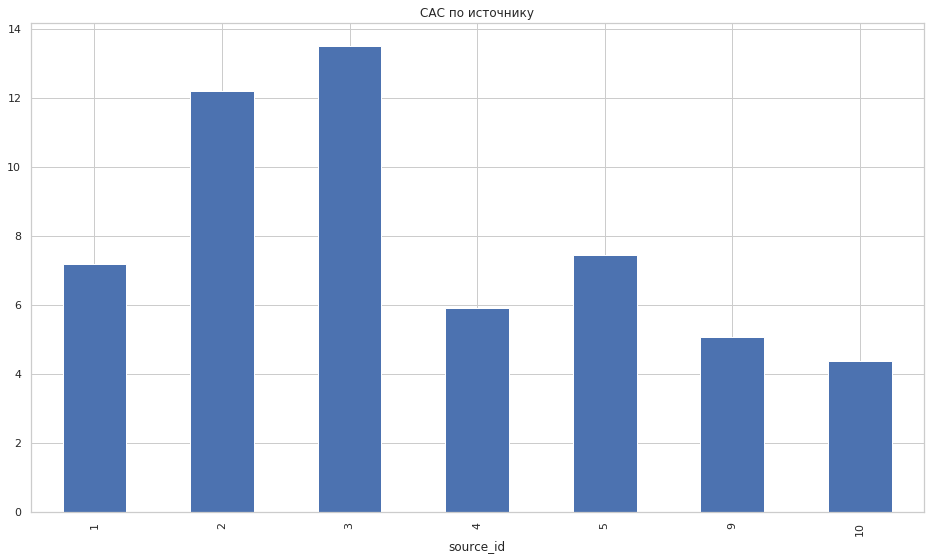

In [167]:
cac['cac'].plot(kind='bar', figsize = (16, 9))
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

#### Вывод  

Источник 3, с которого пришло наибольшее количество посетителей на сайт является наиболее дорогостоящим. Закономерно урезать бюджет данных источников в пользу других источников, например 4 и 5.

Заметно, что в таблице отсутствуют затраты на источники 6, 7 и 8. 8 отсутствует и в таблице с посещениями.

Предположительно, ставка на источник номер 3 была сделана для того, чтобы привлечь как можно больше пользователей, а затем, когда наберется большая аудитория, ожидать, что их рекомендации приведут больше пользователей. Судя по Retention Rate, пользователи неохотно возвращались и вряд ли будут рекомендовать пользоваться сервисом своим знакомым.

<a id='4.3'><a/> 
#### 4.3 Маркетинг. На сколько окупились расходы (ROI, ROMI).
[Назад к оглавлению](#back)

### Посчитаем ROI

In [168]:
cac.reset_index()

,source_id,costs,cohort_size,cac
0,1,20833.27,2896,7.193809
1,2,42806.04,3503,12.219823
2,3,141321.63,10467,13.501637
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1327,4.387709


In [169]:
visits_by_source = visits.query('start_ts == first_visit')

In [170]:
revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'})
revenue_by_source.reset_index()

,source_id,revenue
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


In [171]:
roi = revenue_by_source.join(cac)
roi

,revenue,costs,cohort_size,cac
source_id,,,,
1,31090.55,20833.27,2896.0,7.193809
2,46923.61,42806.04,3503.0,12.219823
3,54511.24,141321.63,10467.0,13.501637
4,56696.83,61073.60,10296.0,5.931779
5,52624.02,51757.10,6931.0,7.467479
7,1.22,NaN,NaN,NaN
9,5759.40,5517.49,1088.0,5.071222
10,4450.33,5822.49,1327.0,4.387709


In [172]:
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']

In [173]:
roi.sort_values('roi', ascending = False)

,revenue,costs,cohort_size,cac,roi
source_id,,,,,
1,31090.55,20833.27,2896.0,7.193809,0.492351
2,46923.61,42806.04,3503.0,12.219823,0.096191
9,5759.40,5517.49,1088.0,5.071222,0.043844
5,52624.02,51757.10,6931.0,7.467479,0.016750
4,56696.83,61073.60,10296.0,5.931779,-0.071664
10,4450.33,5822.49,1327.0,4.387709,-0.235665
3,54511.24,141321.63,10467.0,13.501637,-0.614275
7,1.22,NaN,NaN,NaN,NaN


Наилучший по окупаемости источник номер 1.

### Тперь посчитаем ROMI

In [174]:
romi = ltv.merge(cac[['cac']], on = 'source_id')

In [175]:
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')
romi

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.856648,0.995056,1.098073,1.188049,1.256449,1.287311,1.325542,1.372997,1.418138,1.454263,1.469110,1.485245,1.492351
2,0.554659,0.660027,0.795973,0.921755,0.974705,1.022559,1.041939,1.060528,1.078791,1.083886,1.093177,1.095915,1.096191
3,0.331837,0.350482,0.360595,0.371148,0.376696,0.379623,0.381432,0.383408,0.384793,0.385172,0.385559,0.385643,0.385725
4,0.772915,0.798770,0.818014,0.834255,0.854442,0.881112,0.900634,0.908838,0.912094,0.918484,0.927652,0.928116,0.928336
5,0.657502,0.684862,0.732506,0.915536,0.947140,0.970386,0.986304,0.998329,1.006381,1.014569,1.015436,1.016716,1.016750
9,0.765279,0.821772,0.869223,0.922635,0.944188,0.973254,0.997615,1.010922,1.034155,1.042150,1.043844,1.043844,1.043844
10,0.722222,0.736671,0.742894,0.753818,0.757018,0.757621,0.760704,0.763129,0.763757,0.764335,0.764335,0.764335,0.764335


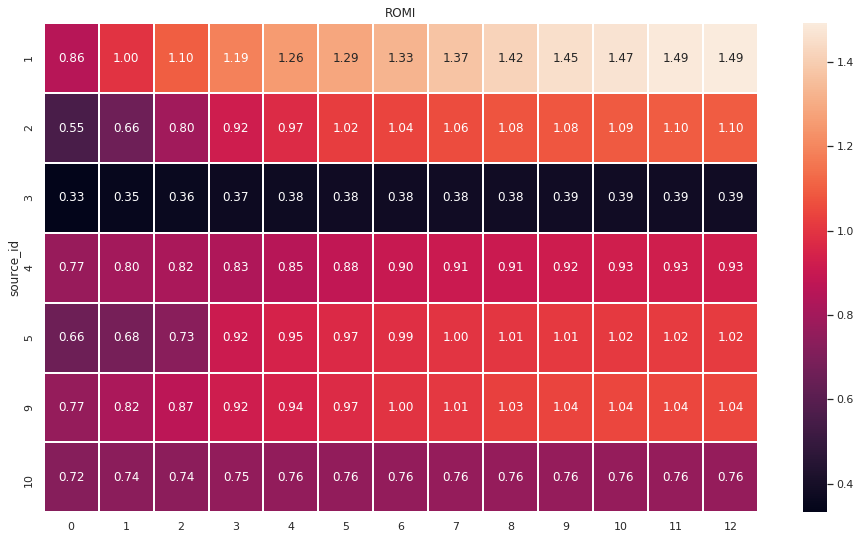

In [176]:
#посмтроим тепловую карту
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('ROMI')
ax = sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, linecolor='white')
plt.show()

Источник номер 3 показывает себя как самый неокупаемый. Тут так же источник номер 1 показывает себя как самый окупаемый. Наиболее выгодные источники по окупаемости это 1 и 2. Также 5 и 9 показывают себя лучше, чем 3.

In [177]:
visits_by_source = visits.query('start_ts == first_visit')

revenue_by_source_and_device = (orders.merge(visits_by_source, on='uid', how='inner'))\
                                .groupby(['source_id', 'device']).agg({'revenue':'sum'})

revenue_by_source_and_device = revenue_by_source_and_device.reset_index()

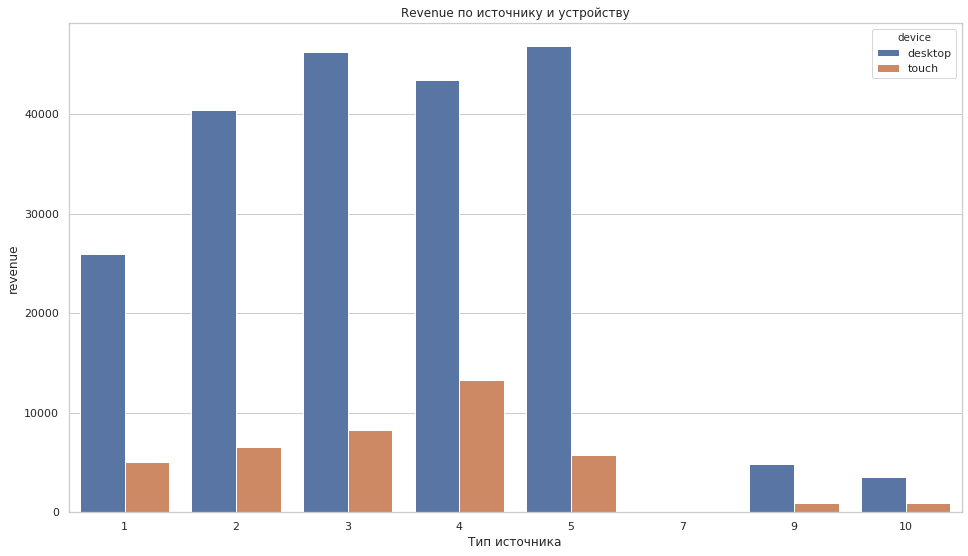

In [178]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="source_id", y="revenue", hue="device", data=revenue_by_source_and_device)
plt.title('Revenue по источнику и устройству')
ax.set_xlabel('Тип источника')
ax.set_ylabel('revenue')
plt.show()

#### Вывод  

Источник номер 3 самый затратный и при этом самый неокупаемый. Следовательно наилучшие источники 1, 2, и 5.

<a id='5'><a/> 
## 5 Вывод. Рекомендации маркетологам, куда и сколько им стоит вкладывать денег.
[Назад к оглавлению](#back)

• На первый взгляд источник 3 наиболее эффективный, но так же он является и наиболее затратным по средствам. В следствии чего профит он дает не большой и является неокупаемым.

• По моему мнению, наибольшее внимание стоит уделить источникам 1, 2 и 5. Возможно, вложить в них больше средств, так как они наиболее профитный по окупаемости.  

• Источники 9 и 10 являются дешевыми, однако, не очень эффективными. Возможно эти источники плохо масштабируются: стоимость привлечения каждого последующего клиента будет стоить большего количества денег.

• Исследования показали, что пользователи более склонны к использованию десктопной версии. Вероятно, что совершать покупки удобнее использовать ее, а мобильная версия больше пригдна для ознакомления с контентом. Сейчас у каждого человека есть телефон, в котором он проводит много времени. Возможно, стоит уделить внимание доработке мобильной версии, сделать ее более простой и понятной в использовании, чтбы с нее было проще совершать покупки, это будет преимуществом. С другой стороны, если бюджет не позволяет в данный момент подобную доработку, то возможно стоит уделить внимание десктопной версии.

• Присутствуют странные источники, такие как 6,7 и источник 8 полностью отсуствует в данных.  

• Большинство посетителей стайта совершают не более одного посещения сайта, сотвественно сервис можно считать "одноразовым". Возможно стоит придумать дополнительные фичи на сайте, кторые будут привлекать посетителей и побуждать их возвращаться. Можно добавить геймификацию: при каждом заходе на сайт посетителю будет предлагаться пройти викторину или некую простую игру, связанную с мероприятими. В случае победы он может выиграть маленький приятный бонус от Яндекса связанный с его предпочтениями и интересами. 